In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats import entropy

In [2]:
# Load the CSV file
result_csv_path = './outputs/inference_results/result_eval_final.csv'
df = pd.read_csv(result_csv_path)
# df = df[df["mode"] == "val"]

df = df[df["mode"] == "test"]
display(df.head())

,mode,annot_ids,annotation,prob_ensemble,prob_model_0,prob_model_1,prob_model_2,prob_model_3,prob_model_4,prob_model_5,prob_model_6
0,test,113597_2_19990102,0.0,0.450226,0.461690,0.406068,0.493420,0.491179,0.425453,0.431546,0.442224
1,test,203326_1_19990102,0.0,0.514367,0.510005,0.468211,0.535578,0.572495,0.561985,0.466408,0.485887
2,test,203326_4_19990102,0.0,0.512021,0.503758,0.482172,0.509056,0.533473,0.566604,0.488359,0.500726
3,test,203326_3_19990102,0.0,0.516217,0.502623,0.518407,0.531199,0.567488,0.508173,0.503931,0.481700
4,test,203326_2_19990102,0.0,0.548913,0.517107,0.523086,0.563366,0.596406,0.606761,0.531417,0.504249


In [3]:
# Basic statistics
print("\n📝 Basic Statistics")
print(df.describe())


📝 Basic Statistics
        annotation  prob_ensemble  prob_model_0  prob_model_1  prob_model_2  \
count  6163.000000    6163.000000   6163.000000   6163.000000   6163.000000   
mean      0.090054       0.485927      0.480858      0.470979      0.502211   
std       0.286282       0.051768      0.050575      0.061097      0.058696   
min       0.000000       0.287080      0.256517      0.262336      0.253162   
25%       0.000000       0.453580      0.452128      0.432497      0.462652   
50%       0.000000       0.472067      0.470863      0.453337      0.487895   
75%       0.000000       0.505902      0.501129      0.492690      0.533695   
max       1.000000       0.721922      0.731636      0.742562      0.736508   

       prob_model_3  prob_model_4  prob_model_5  prob_model_6  
count   6163.000000   6163.000000   6163.000000   6163.000000  
mean       0.492357      0.487870      0.469403      0.497812  
std        0.057776      0.060332      0.051988      0.054802  
min        0

In [4]:
# Extract model probability columns (e.g., prob_model_0, prob_model_1, ...)
ensemble_col = 'prob_ensemble'
model_cols = [col for col in df.columns if col.startswith('prob_model_')]


📊 AUROC Scores (with 95% CI)
prob_model_0 AUROC: 0.8001 (95% CI: 0.7775 - 0.8227)
prob_model_1 AUROC: 0.7846 (95% CI: 0.7615 - 0.8077)
prob_model_2 AUROC: 0.7983 (95% CI: 0.7757 - 0.8210)
prob_model_3 AUROC: 0.7982 (95% CI: 0.7755 - 0.8208)
prob_model_4 AUROC: 0.7665 (95% CI: 0.7428 - 0.7902)
prob_model_5 AUROC: 0.7771 (95% CI: 0.7537 - 0.8004)
prob_model_6 AUROC: 0.7793 (95% CI: 0.7560 - 0.8026)
prob_ensemble AUROC: 0.8071 (95% CI: 0.7848 - 0.8294)


/tmp/ipykernel_1095612/2983406646.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Model", y="AUROC", data=auroc_df, ci=None, palette="Set2")
/tmp/ipykernel_1095612/2983406646.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="AUROC", data=auroc_df, ci=None, palette="Set2")


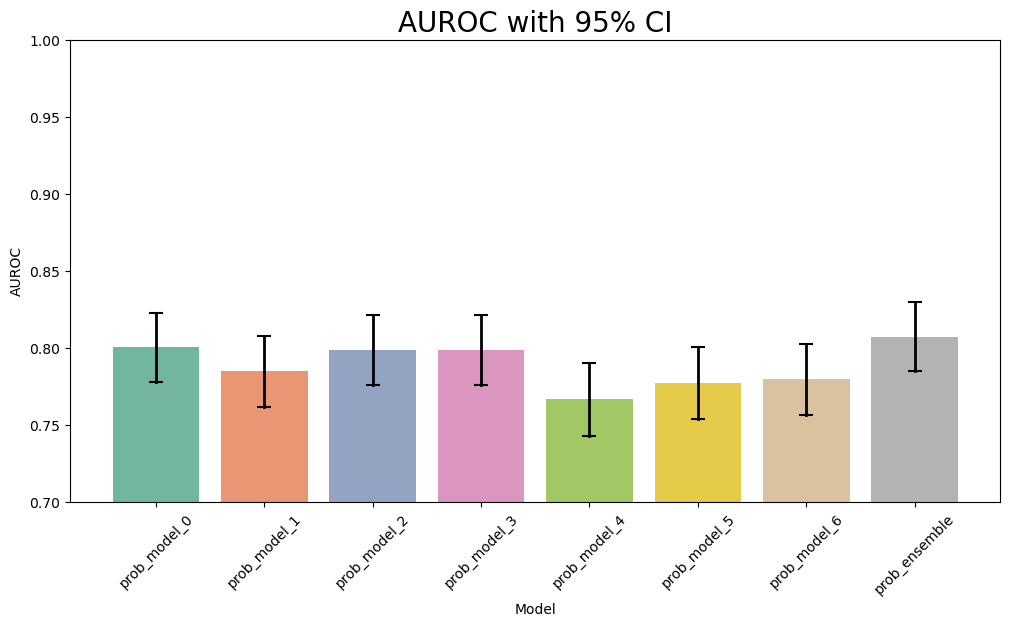

In [5]:
# Calculate AUROC scores with 95% CI
print("\n📊 AUROC Scores (with 95% CI)")
y_true = df['annotation']
auroc_scores = {}
auroc_cis = {}
for col in model_cols + [ensemble_col]:
    # Calculate AUROC
    auroc = roc_auc_score(y_true, df[col])
    auroc_scores[col] = auroc
    
    # Calculate 95% CI using DeLong method approximation
    n1 = sum(y_true == 1)
    n2 = sum(y_true == 0)
    q1 = auroc / (2 - auroc)
    q2 = 2 * (auroc ** 2) / (1 + auroc)
    se = np.sqrt((auroc * (1 - auroc) + (n1 - 1) * (q1 - auroc**2) + (n2 - 1) * (q2 - auroc**2)) / (n1 * n2))
    ci_lower = auroc - 1.96 * se
    ci_upper = auroc + 1.96 * se
    auroc_cis[col] = (ci_lower, ci_upper)
    
    print(f'{col} AUROC: {auroc:.4f} (95% CI: {ci_lower:.4f} - {ci_upper:.4f})')

# Plot AUROC with 95% CI
plt.figure(figsize=(12, 6))
auroc_df = pd.DataFrame(auroc_scores.items(), columns=["Model", "AUROC"])
auroc_df["CI Lower"], auroc_df["CI Upper"] = zip(*auroc_cis.values())
sns.barplot(x="Model", y="AUROC", data=auroc_df, ci=None, palette="Set2")
for i, (ci_lower, ci_upper) in enumerate(auroc_cis.values()):
    plt.plot([i, i], [ci_lower, ci_upper], color="black", linewidth=2)
    plt.scatter([i], [ci_lower], color="black", marker="_", s=100)
    plt.scatter([i], [ci_upper], color="black", marker="_", s=100)
plt.title("AUROC with 95% CI", fontsize=20)
plt.xticks(rotation=45)
plt.ylim(0.7, 1.0)
plt.show()


📊 Sensitivity and Specificity at 95% Thresholds
prob_model_0 - Sensitivity (95% Specificity): 0.3369, Specificity (95% Sensitivity): 0.1969
prob_model_1 - Sensitivity (95% Specificity): 0.3117, Specificity (95% Sensitivity): 0.1410
prob_model_2 - Sensitivity (95% Specificity): 0.3405, Specificity (95% Sensitivity): 0.1571
prob_model_3 - Sensitivity (95% Specificity): 0.3351, Specificity (95% Sensitivity): 0.1812
prob_model_4 - Sensitivity (95% Specificity): 0.3351, Specificity (95% Sensitivity): 0.0847
prob_model_5 - Sensitivity (95% Specificity): 0.3351, Specificity (95% Sensitivity): 0.1159
prob_model_6 - Sensitivity (95% Specificity): 0.3730, Specificity (95% Sensitivity): 0.0802
prob_ensemble - Sensitivity (95% Specificity): 0.3441, Specificity (95% Sensitivity): 0.1674


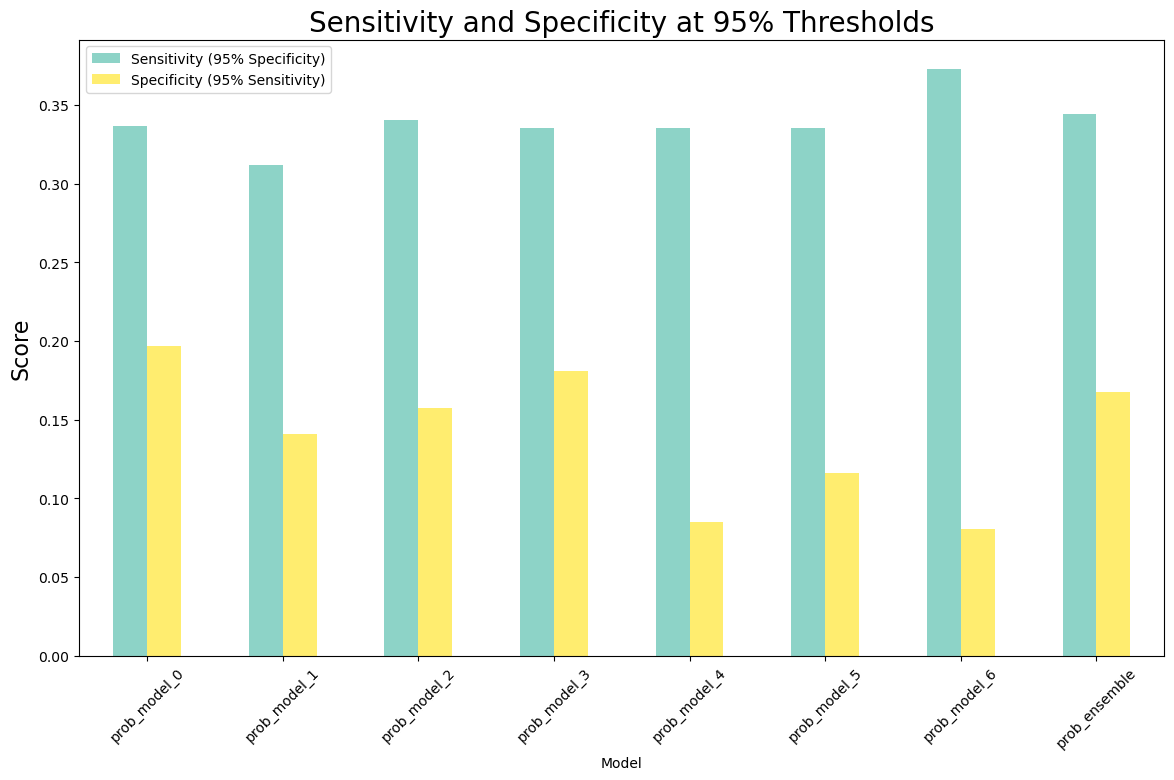

In [6]:
y_true = df['annotation']

# Sensitivity at 95% Specificity & Specificity at 95% Sensitivity
print("\n📊 Sensitivity and Specificity at 95% Thresholds")
threshold_metrics = {}
for col in model_cols + [ensemble_col]:
    fpr, tpr, thresholds = roc_curve(y_true, df[col])

    # Sensitivity at 95% Specificity
    specificity_threshold_idx = np.where(1 - fpr >= 0.95)[0]
    if len(specificity_threshold_idx) > 0:
        sensitivity_95 = max(tpr[specificity_threshold_idx])
    else:
        sensitivity_95 = np.nan  # 또는 0으로 처리

    # Specificity at 95% Sensitivity
    sensitivity_threshold_idx = np.where(tpr >= 0.95)[0]
    if len(sensitivity_threshold_idx) > 0:
        specificity_95 = max(1 - fpr[sensitivity_threshold_idx])
    else:
        specificity_95 = np.nan  # 또는 0으로 처리

    threshold_metrics[col] = (sensitivity_95, specificity_95)
    print(f"{col} - Sensitivity (95% Specificity): {sensitivity_95:.4f}, Specificity (95% Sensitivity): {specificity_95:.4f}")

# Plot Sensitivity and Specificity
threshold_df = pd.DataFrame(threshold_metrics.items(), columns=["Model", "Metrics"])
threshold_df["Sensitivity (95% Specificity)"], threshold_df["Specificity (95% Sensitivity)"] = zip(*threshold_df["Metrics"])
threshold_df.drop(columns=["Metrics"], inplace=True)
threshold_df.set_index("Model", inplace=True)
threshold_df.plot(kind="bar", figsize=(14, 8), colormap="Set3")
plt.title("Sensitivity and Specificity at 95% Thresholds", fontsize=20)
plt.xticks(rotation=45)
plt.ylabel("Score", fontsize=16)
# plt.ylim(0.2, 1.0)
plt.show()


📊 AUROC Scores
prob_model_0 AUROC: 0.8001
prob_model_1 AUROC: 0.7846
prob_model_2 AUROC: 0.7983
prob_model_3 AUROC: 0.7982
prob_model_4 AUROC: 0.7665
prob_model_5 AUROC: 0.7771
prob_model_6 AUROC: 0.7793
prob_ensemble AUROC: 0.8071


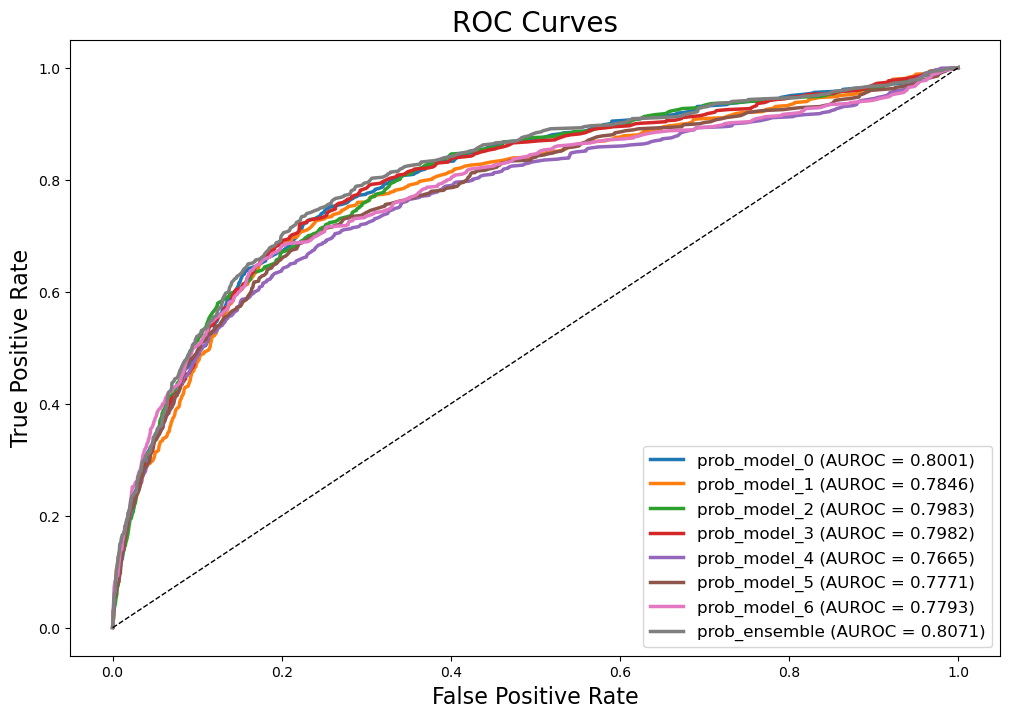

In [7]:
# Calculate AUROC scores
print("\n📊 AUROC Scores")
y_true = df['annotation']
auroc_scores = {}
for col in model_cols + [ensemble_col]:
    auroc_scores[col] = roc_auc_score(y_true, df[col])
    print(f'{col} AUROC: {auroc_scores[col]:.4f}')

# Plot ROC curves (Seaborn)
plt.figure(figsize=(12, 8))
for col in model_cols + [ensemble_col]:
    fpr, tpr, _ = roc_curve(y_true, df[col])
    sns.lineplot(x=fpr, y=tpr, label=f'{col} (AUROC = {auroc_scores[col]:.4f})', linewidth=2.5)

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title('ROC Curves', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.show()


🔗 Correlation Matrix


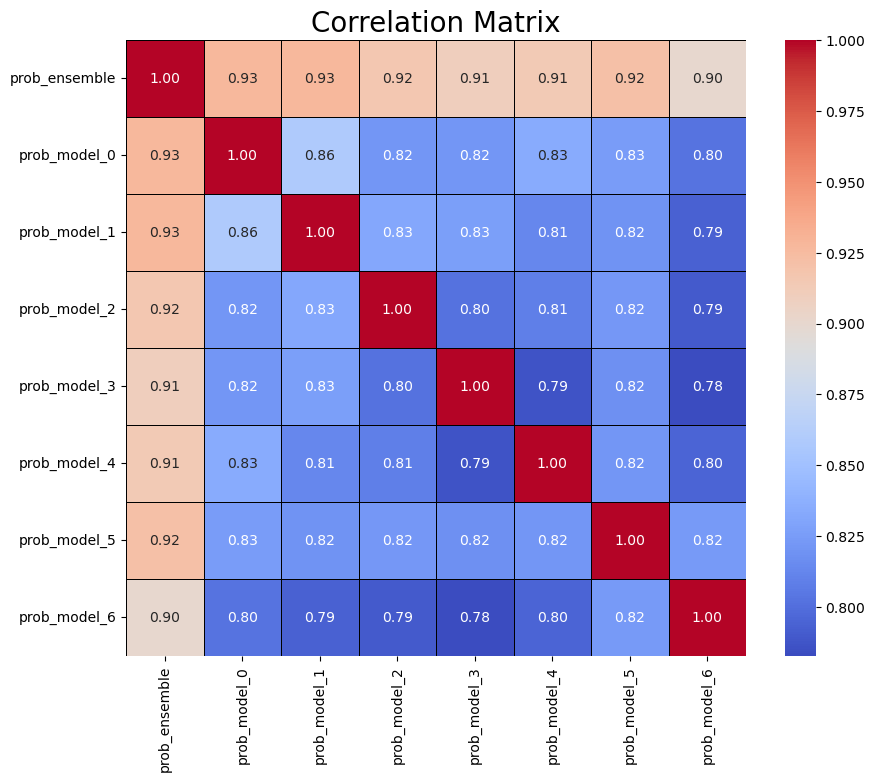

In [8]:
# Correlation matrix (Seaborn)
print("\n🔗 Correlation Matrix")
corr_matrix = df[[ensemble_col] + model_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, linecolor='black')
plt.title('Correlation Matrix', fontsize=20)
plt.show()

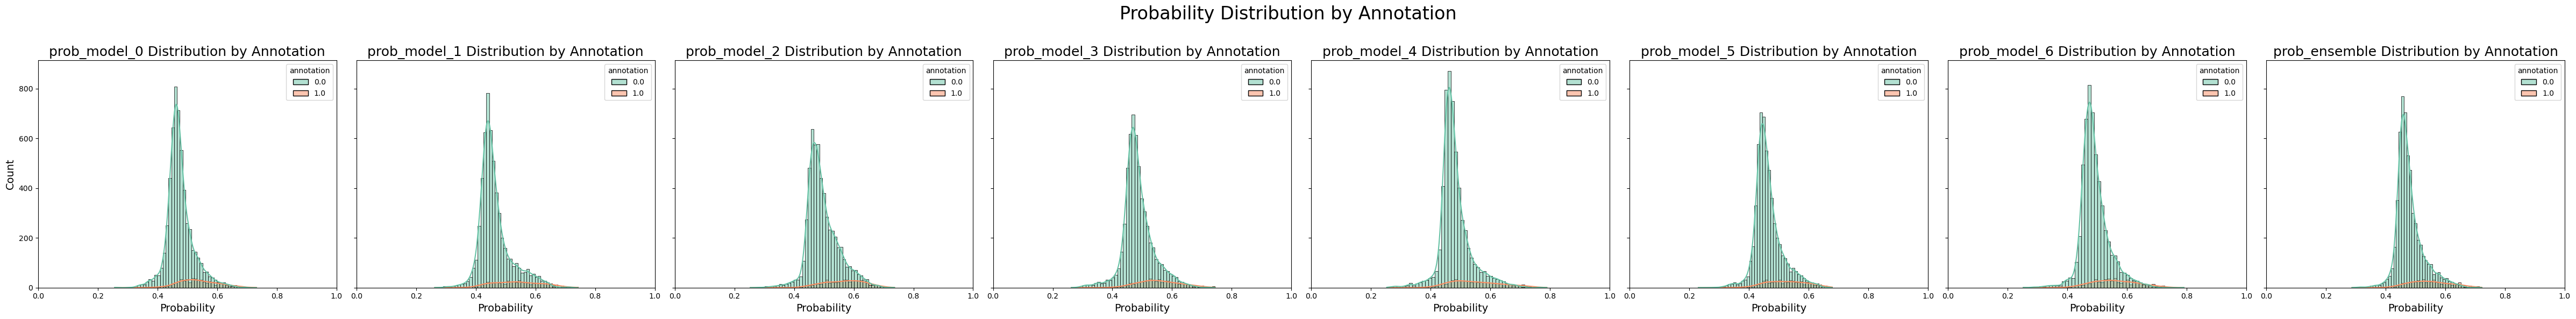

In [9]:
# Probability distribution per annotation (Seaborn, col-wise layout)
_model_cols = model_cols + [ensemble_col]
num_models = len(_model_cols)
fig, axes = plt.subplots(1, num_models, figsize=(6 * num_models, 6), sharey=True)
fig.suptitle("Probability Distribution by Annotation", fontsize=24)

for i, model_col in enumerate(_model_cols):
    sns.histplot(data=df, x=model_col, hue="annotation", bins=50, kde=True, ax=axes[i], alpha=0.5, palette="Set2")
    axes[i].set_title(f"{model_col} Distribution by Annotation", fontsize=18)
    axes[i].set_xlabel("Probability", fontsize=14)
    axes[i].set_ylabel("Count", fontsize=14)
    axes[i].set_xlim(0.0, 1.0)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

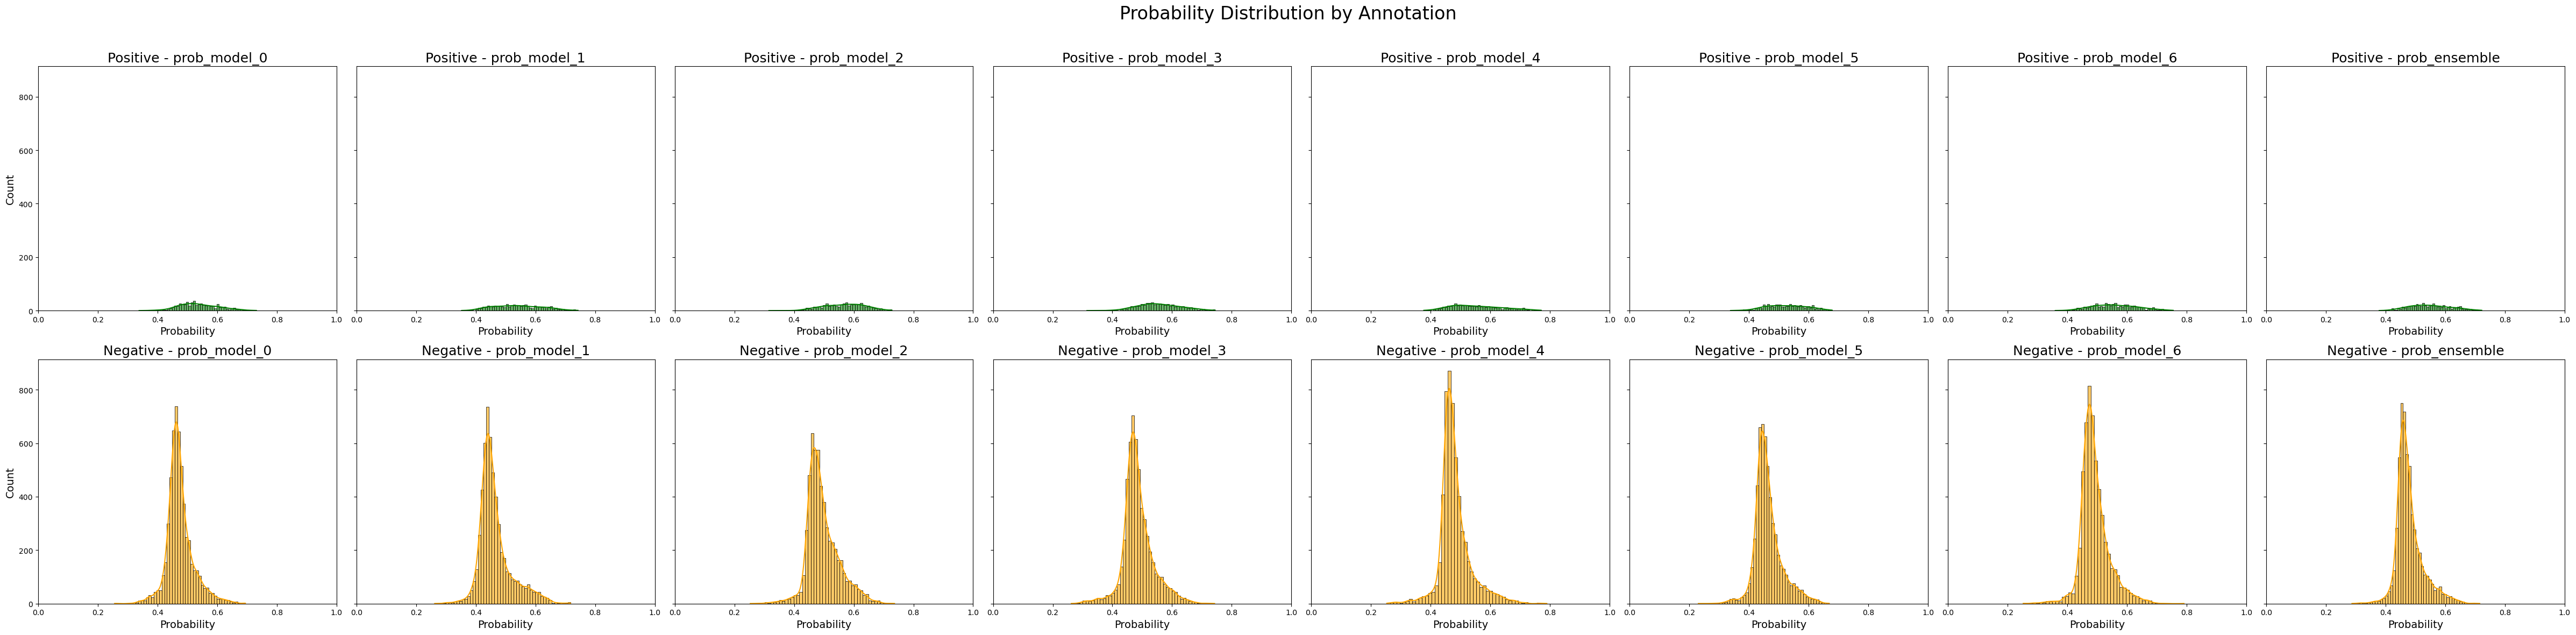

In [10]:
# Extract model probability columns (e.g., prob_model_0, prob_model_1, ...)
_model_cols = model_cols + [ensemble_col]

# Probability distribution by annotation (Seaborn, row-wise layout)
num_models = len(_model_cols)
fig, axes = plt.subplots(2, num_models, figsize=(6 * num_models, 12), sharey=True)
fig.suptitle("Probability Distribution by Annotation", fontsize=24)

for i, model_col in enumerate(_model_cols):
    # Positive annotation
    sns.histplot(data=df[df['annotation'] == 1], x=model_col, bins=50, kde=True, ax=axes[0, i], alpha=0.6, color="green")
    axes[0, i].set_title(f"Positive - {model_col}", fontsize=18)
    axes[0, i].set_xlabel("Probability", fontsize=14)
    axes[0, i].set_ylabel("Count", fontsize=14)
    axes[0, i].set_xlim(0.0, 1.0)

    # Negative annotation
    sns.histplot(data=df[df['annotation'] == 0], x=model_col, bins=50, kde=True, ax=axes[1, i], alpha=0.6, color="orange")
    axes[1, i].set_title(f"Negative - {model_col}", fontsize=18)
    axes[1, i].set_xlabel("Probability", fontsize=14)
    axes[1, i].set_ylabel("Count", fontsize=14)
    axes[1, i].set_xlim(0.0, 1.0)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


🧮 Entropy Analysis

📝 Entropy Summary
       prob_model_0  prob_model_1  prob_model_2  prob_model_3  prob_model_4  \
count   6163.000000   6163.000000   6163.000000   6163.000000   6163.000000   
mean       0.991502      0.986697      0.989950      0.990096      0.988927   
std        0.013873      0.016493      0.017786      0.018839      0.022586   
min        0.821445      0.822855      0.816251      0.820364      0.743095   
25%        0.990977      0.983789      0.990707      0.991064      0.990870   
50%        0.995804      0.990736      0.996176      0.996484      0.995761   
75%        0.998596      0.996392      0.998947      0.999026      0.998664   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       prob_model_5  prob_model_6  prob_ensemble  
count   6163.000000   6163.000000    6163.000000  
mean       0.989433      0.991225       0.991636  
std        0.013459      0.018452       0.013954  
min        0.778381      0.739980       0.852

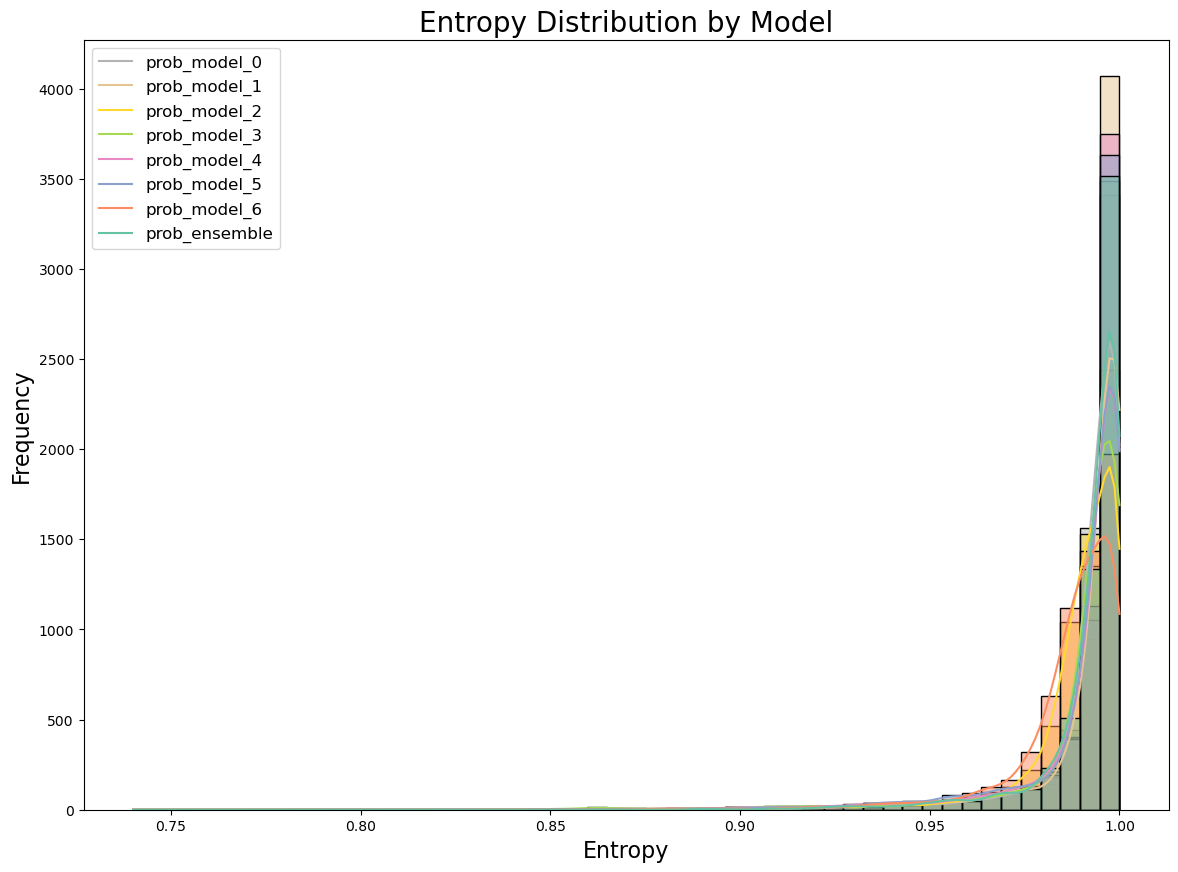

In [11]:
# Entropy calculation
print("\n🧮 Entropy Analysis")
entropy_df = pd.DataFrame()
for col in model_cols + [ensemble_col]:
    probs = df[col].values
    entropies = -(probs * np.log2(probs + 1e-10) + (1 - probs) * np.log2(1 - probs + 1e-10))
    entropy_df[col] = entropies

# Entropy summary
print("\n📝 Entropy Summary")
print(entropy_df.describe())

# Plot entropy distributions (Seaborn)
plt.figure(figsize=(14, 10))
sns.histplot(entropy_df, kde=True, bins=50, alpha=0.5, palette='Set2')
plt.title('Entropy Distribution by Model', fontsize=20)
plt.xlabel('Entropy', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.legend(entropy_df.columns, fontsize=12)
plt.show()

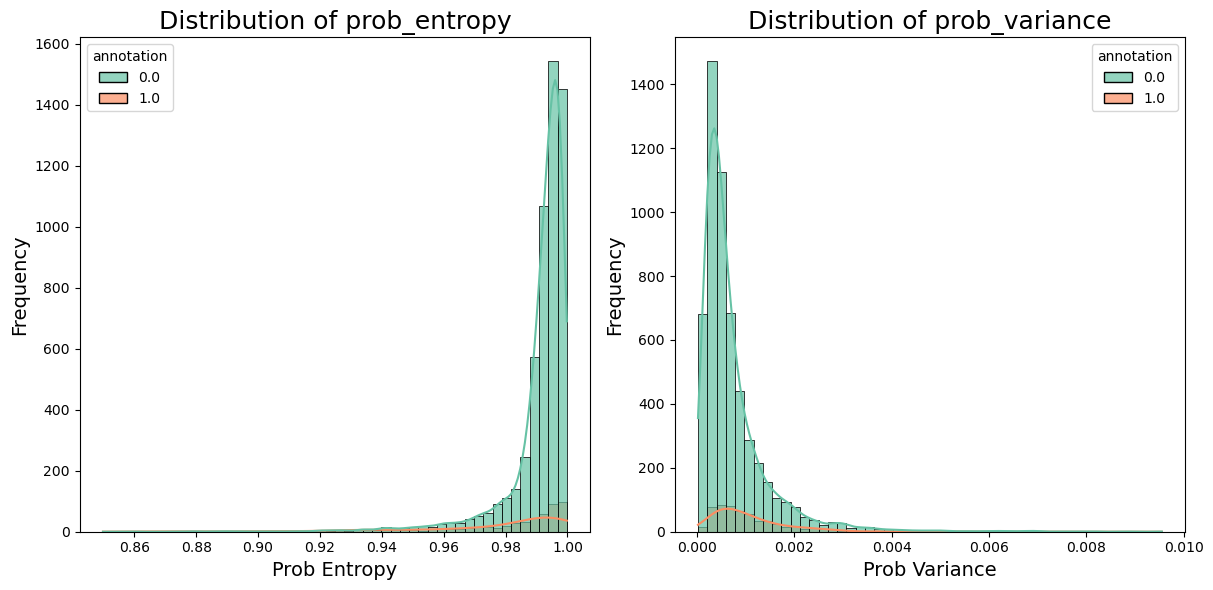


📝 Metric Summary Statistics
       prob_entropy  prob_variance
count   6163.000000    6163.000000
mean       0.989690       0.000772
std        0.014503       0.000794
min        0.849871       0.000020
25%        0.989456       0.000313
50%        0.993985       0.000527
75%        0.996796       0.000932
max        0.999780       0.009549


In [12]:
# Extract model probability columns (e.g., prob_model_0, prob_model_1, ...)
ensemble_col = 'prob_ensemble'
model_cols = [col for col in df.columns if col.startswith('prob_model_')]

# Correct entropy calculation for binary classification
binary_entropies = []
for _, row in df[model_cols].iterrows():
    entropies = - (row.values * np.log2(row.values + 1e-10) + (1 - row.values) * np.log2(1 - row.values + 1e-10))
    binary_entropies.append(np.mean(entropies))

df["prob_entropy"] = binary_entropies
df["prob_variance"] = df[model_cols].var(axis=1)

# Plot distributions
metrics = ["prob_entropy", "prob_variance"]
plt.figure(figsize=(18, 6))
for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i + 1)
    sns.histplot(data=df, x=metric, hue="annotation", bins=50, kde=True, palette="Set2", alpha=0.7)
    plt.title(f"Distribution of {metric}", fontsize=18)
    plt.xlabel(metric.replace('_', ' ').title(), fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
plt.tight_layout()
plt.show()

# Summary statistics
print("\n📝 Metric Summary Statistics")
print(df[metrics].describe())

In [13]:
# Sort by entropy, variance, and CV for each annotation
sorted_positive = df[df["annotation"] == 1].sort_values(by="prob_variance", ascending=False)
sorted_negative = df[df["annotation"] == 0].sort_values(by="prob_variance", ascending=False)

# Select top N samples
N = 20
top_positive = sorted_positive.head(N)
top_negative = sorted_negative.head(N)

# Display the selected samples
print("\n🔎 Top Positive Samples (High variance)")
print(top_positive[["annotation", "prob_entropy", "prob_variance"] + model_cols].reset_index(drop=True))

print("\n🔎 Top Negative Samples (High variance)")
print(top_negative[["annotation", "prob_entropy", "prob_variance"] + model_cols].reset_index(drop=True))


🔎 Top Positive Samples (High variance)
    annotation  prob_entropy  prob_variance  prob_model_0  prob_model_1  \
0          1.0      0.971653       0.007192      0.592249      0.425024   
1          1.0      0.973113       0.006120      0.515518      0.541983   
2          1.0      0.981994       0.005305      0.572957      0.611237   
3          1.0      0.983446       0.005189      0.523626      0.388631   
4          1.0      0.986962       0.005156      0.466295      0.477093   
5          1.0      0.981844       0.004854      0.587111      0.582426   
6          1.0      0.987175       0.004827      0.436352      0.484549   
7          1.0      0.960482       0.004702      0.548853      0.518270   
8          1.0      0.988685       0.004516      0.523890      0.403378   
9          1.0      0.986070       0.004485      0.537855      0.440911   
10         1.0      0.984741       0.004464      0.478403      0.449662   
11         1.0      0.972627       0.004036      0.561092   

In [14]:
import pymongo

from data_lake.constants import DB_ADDRESS, TARGET_COLLECTION, TARGET_DB

_CLIENT = pymongo.MongoClient(DB_ADDRESS)
_TARGET_FIELD = {}
_PROJECTION = {field: 1 for field in _TARGET_FIELD}

for _, row in top_positive.iterrows():
    query = {"annotation_id": row.annot_ids}
    nodule_candidates = [x for x in _CLIENT[TARGET_DB][TARGET_COLLECTION].find(query, _PROJECTION)]
    break


In [15]:
nodule_candidates

[{'_id': ObjectId('67f76d77e2847ff46115c37d'),
  'patient_id': 103703,
  'series_instance_uid': '1.2.840.113654.2.55.17946222853752357522036394138531044474',
  'annotation_id': '103703_1_19990102',
  'studydate': 19990102,
  'h5_path_nfs': '/team/team_blu3/lung/data/2_public/LUNA25_h5/1.2.840.113654.2.55.17946222853752357522036394138531044474.h5',
  'h5_path': '/nvme1/1_dataset/LUNA25_h5/1.2.840.113654.2.55.17946222853752357522036394138531044474.h5',
  'fold': 3,
  'label': 1,
  'age_at_study': 60,
  'gender': 'Female',
  'origin': [-287.55999755859375, -149.5, -138.0],
  'transform': [[1.25, 0.0, 0.0],
   [0.0, 0.5390620231628418, 0.0],
   [0.0, 0.0, 0.5390620231628418]],
  'spacing': [1.25, 0.5390620231628418, 0.5390620231628418],
  'resampled_spacing': [1.0, 0.67, 0.67],
  'w_coord_zyx': [-76.41, -11.3, -45.04],
  'd_coord_zyx': [168.919998046875, 256.37124127041693, 172.44768877350188],
  'r_coord_zyx': [211.31824456860062, 205.69903898409186, 138.36311623705632],
  'fold_10': 5,
 